<a href="https://colab.research.google.com/github/RahulYaramaneni7/DeepFakeAudio/blob/main/AudioDeepFakeDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
rahulyaramaneni_audiodeepfake_path = kagglehub.dataset_download('rahulyaramaneni/audiodeepfake')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/audiodeepfake/DS_10283_3055/README_V2.txt
/kaggle/input/audiodeepfake/DS_10283_3055/Instructions_V2.txt
/kaggle/input/audiodeepfake/DS_10283_3055/asvspoof2017_evalplan_v1.1.pdf
/kaggle/input/audiodeepfake/DS_10283_3055/ASVspoof2017_V2_Odyssey_2018.pdf
/kaggle/input/audiodeepfake/DS_10283_3055/asvspoof2017_interspeech2017_summary.pdf
/kaggle/input/audiodeepfake/DS_10283_3055/CHANGE_LOG_V2.txt
/kaggle/input/audiodeepfake/DS_10283_3055/ASVspoof2017_V2_eval/ASVspoof2017_V2_eval/E_1008402.wav
/kaggle/input/audiodeepfake/DS_10283_3055/ASVspoof2017_V2_eval/ASVspoof2017_V2_eval/E_1006847.wav
/kaggle/input/audiodeepfake/DS_10283_3055/ASVspoof2017_V2_eval/ASVspoof2017_V2_eval/E_1004531.wav
/kaggle/input/audiodeepfake/DS_10283_3055/ASVspoof2017_V2_eval/ASVspoof2017_V2_eval/E_1007371.wav
/kaggle/input/audiodeepfake/DS_10283_3055/ASVspoof2017_V2_eval/ASVspoof2017_V2_eval/E_1011725.wav
/kaggle/input/audiodeepfake/DS_10283_3055/ASVspoof2017_V2_eval/ASVspoof2017_V2_eval/E_1007425.wav
/ka

In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split
from tqdm import tqdm

**DATAPATHS**

In [ ]:
train_audio_path = "/kaggle/input/audiodeepfake/DS_10283_3055/ASVspoof2017_V2_eval/ASVspoof2017_V2_eval"
train_protocol_path = "/kaggle/input/audiodeepfake/DS_10283_3055/protocol_V2/protocol_V2/ASVspoof2017_V2_eval.trl.txt"

In [ ]:
def load_protocol(protocol_path):
    file_labels = {}
    with open(protocol_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            file_id = parts[0]
            label = 1 if parts[1] == "genuine" else 0
            file_labels[file_id] = label
    return file_labels

file_labels = load_protocol(train_protocol_path)


In [ ]:
def extract_features(file_path, max_pad_len=16000):
    try:
        audio, sr = librosa.load(file_path, sr=16000)
        audio = librosa.util.fix_length(audio, size=max_pad_len)  # Pad or truncate
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        return mel_spec_db
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [ ]:
X, y = [], []

for file_id, label in tqdm(file_labels.items(), desc="Extracting Features"):
    file_path = os.path.join(train_audio_path, f"{file_id}")
    if os.path.exists(file_path):
        features = extract_features(file_path)
        if features is not None:
            X.append(features)
            y.append(label)

X = np.array(X)
y = np.array(y)

# Reshape data for EfficientNet (Adding channel dimension)
X = X[..., np.newaxis]  # Shape: (samples, 128, time, 1)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Extracting Features: 100%|██████████| 13306/13306 [04:16<00:00, 51.80it/s]


In [ ]:
#model layers
def create_model(input_shape):
    base_model = EfficientNetB0(include_top=False, input_shape=input_shape, weights=None)
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Model Training
input_shape = (128, X.shape[2], 1)
model = create_model(input_shape)

In [ ]:
class LogEpoch(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[LogEpoch()])

# Save model
model.save("asvspoof_efficientnet.h5")

Epoch 1/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 104s 154ms/step - accuracy: 0.8956 - loss: 0.3677 - val_accuracy: 0.9023 - val_loss: 0.3285
Epoch 2/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9051 - loss: 0.2390 - val_accuracy: 0.7806 - val_loss: 0.4126
Epoch 3/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9348 - loss: 0.1654 - val_accuracy: 0.9418 - val_loss: 0.1718
Epoch 4/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9555 - loss: 0.1230 - val_accuracy: 0.9452 - val_loss: 0.1734
Epoch 5/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9623 - loss: 0.1047 - val_accuracy: 0.9421 - val_loss: 0.1527
Epoch 6/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9686 - loss: 0.0963 - val_accuracy: 0.9576 - val_loss: 0.1345
Epoch 7/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9789 - loss: 0.0645 - val_accuracy: 0.9418 - val_loss: 0.1393
Epoch 8/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9808 - loss: 0.0574 

**CONFUSION MATRIX**

84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step


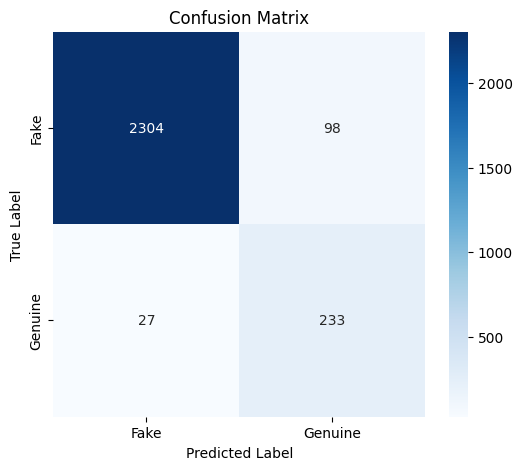

              precision    recall  f1-score   support

        Fake       0.99      0.96      0.97      2402
     Genuine       0.70      0.90      0.79       260

    accuracy                           0.95      2662
   macro avg       0.85      0.93      0.88      2662
weighted avg       0.96      0.95      0.96      2662



In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model("asvspoof_efficientnet.h5")

# Get predictions
y_pred_probs = model.predict(X_val)  # Get probability scores
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary labels

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Display confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Genuine"], yticklabels=["Fake", "Genuine"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report for more detailed metrics
print(classification_report(y_val, y_pred, target_names=["Fake", "Genuine"]))


**ROC CURVE AND AUC SCORE**

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


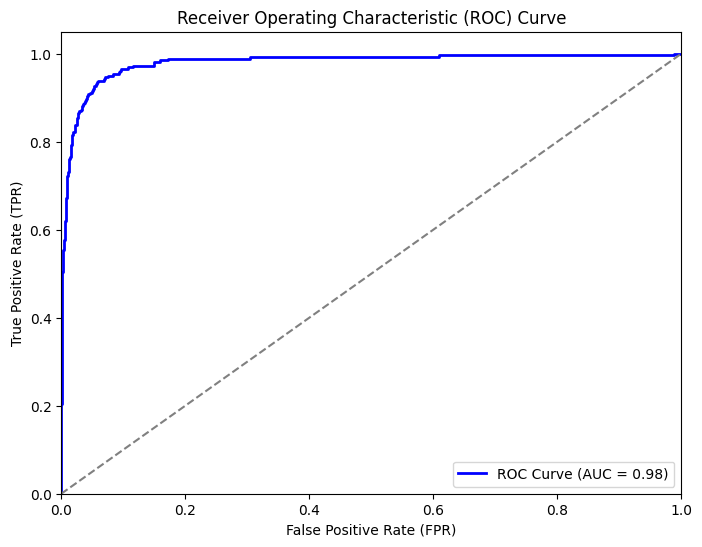

AUC Score: 0.9799


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get model predictions as probabilities
y_pred_probs = model.predict(X_val).ravel()  # Flatten array to 1D

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_val, y_pred_probs)
roc_auc = auc(fpr, tpr)  # Compute AUC score

# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print AUC Score
print(f"AUC Score: {roc_auc:.4f}")


In [ ]:
# Path to ASVspoof 2017 protocol file
protocol_file_path = "/kaggle/input/audiodeepfake/DS_10283_3055/protocol_V2/protocol_V2/ASVspoof2017_V2_train.trn.txt"

# Dictionary to store true labels
true_labels = {}

# Read protocol file and extract labels
with open(protocol_file_path, "r") as file:
    for line in file:
        parts = line.strip().split()  # Split line into parts
        if len(parts) > 1:  # Ensure valid format
            file_id = parts[0]  # First part is the file name
            label = 1 if parts[1] == "genuine" else 0  # Convert label to binary (1 = Genuine, 0 = Fake)
            true_labels[file_id] = label

# Print some extracted labels
print(f"Extracted {len(true_labels)} labels.")
print("Sample labels:", list(true_labels.items())[:5])  # Print first 5 entries


Extracted 3014 labels.
Sample labels: [('T_1000001.wav', 1), ('T_1000002.wav', 1), ('T_1000003.wav', 1), ('T_1000004.wav', 1), ('T_1000005.wav', 1)]


**Model Architecture**

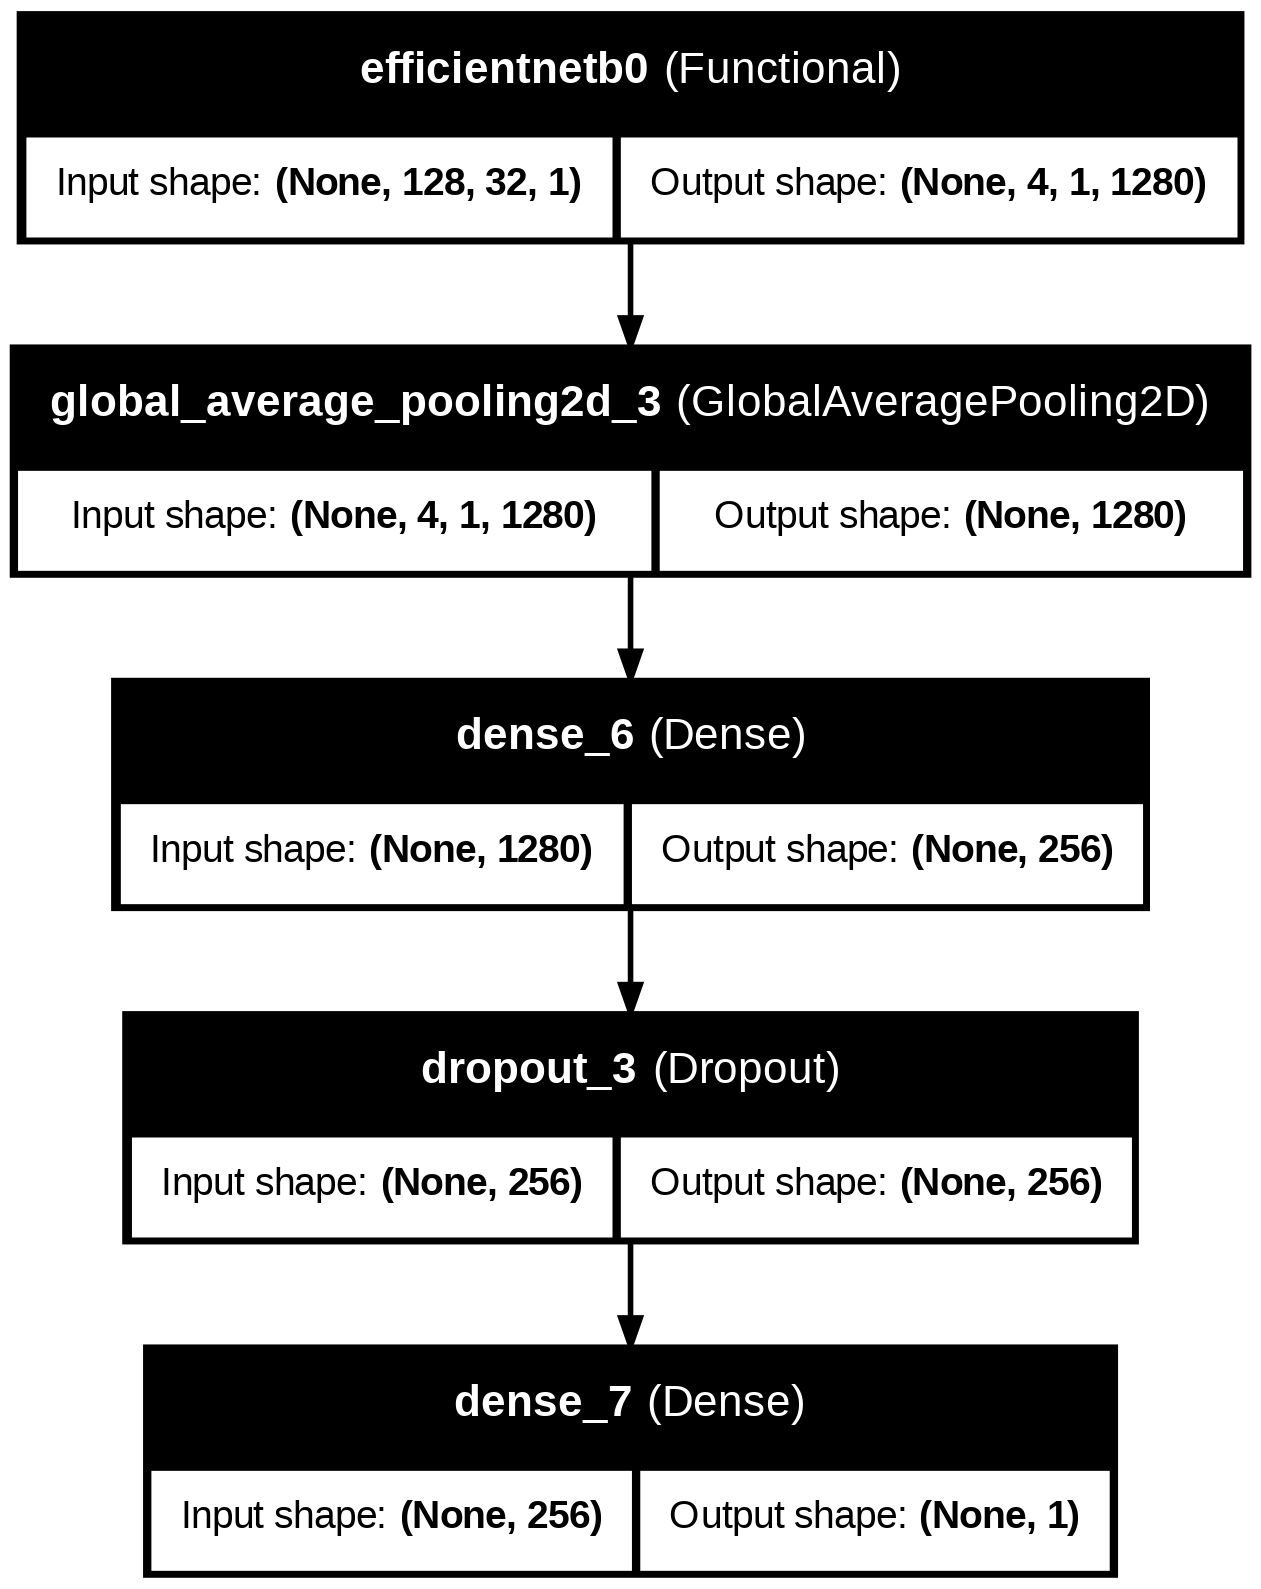

In [ ]:
#model Architecture
from tensorflow.keras.utils import plot_model
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model("asvspoof_efficientnet.h5")

# Plot and save the model architecture
plot_model(model, to_file="model_architecture.png", show_shapes=True, show_layer_names=True)


**VIZUALIZATION OF MEL SPECTROGRAM**

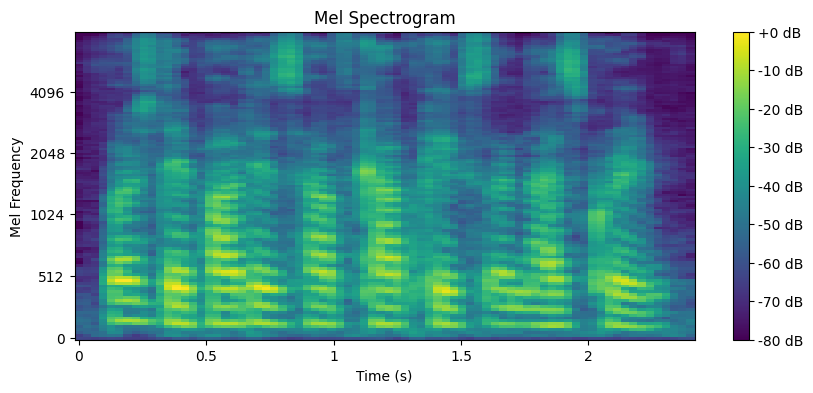

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os

# Set the path to an example audio file from ASVspoof 2017 dataset
audio_file = "/kaggle/input/audiodeepfake/DS_10283_3055/ASVspoof2017_V2_train/ASVspoof2017_V2_train/T_1000001.wav"

# Load the audio file
y, sr = librosa.load(audio_file, sr=16000)  # Use 16kHz sampling rate (ASVspoof standard)

# Compute the Mel Spectrogram
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=sr//2)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to decibels for better visualization

# Plot the Mel Spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')  # Add a color bar
plt.title("Mel Spectrogram")
plt.xlabel("Time (s)")
plt.ylabel("Mel Frequency")
plt.show()


**TESTING WITH SOME OF THE AUDIO FILES**

In [ ]:
import numpy as np
import librosa
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model("asvspoof_efficientnet.h5")

# Function to extract Mel Spectrogram features
def extract_features(file_path, max_pad_len=16000):
    try:
        audio, sr = librosa.load(file_path, sr=16000)
        audio = librosa.util.fix_length(audio, size=max_pad_len)  # Pad or truncate
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        return mel_spec_db
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Function to predict if the audio is real (genuine) or fake (spoof)
def predict_audio(file_path):
    features = extract_features(file_path)
    if features is None:
        return "Error in processing the audio file."

    features = np.expand_dims(features, axis=-1)  # Add channel dimension
    features = np.expand_dims(features, axis=0)   # Add batch dimension (1, 128, time, 1)

    prediction = model.predict(features)[0][0] # Get the first value
    label = "Genuine (Real)" if prediction >= 0.5 else "Fake (Spoof)"

    print(f"Prediction: {label} (Confidence: {prediction:.4f})")
    return label

# Example usage with an audio file
audio_file1 = "/kaggle/input/audiodeepfake/DS_10283_3055/ASVspoof2017_V2_eval/ASVspoof2017_V2_eval/E_1000001.wav" #Fake
audio_file2 = "/kaggle/input/audiodeepfake/DS_10283_3055/ASVspoof2017_V2_train/ASVspoof2017_V2_train/T_1000001.wav" #Real
predict_audio(audio_file1)
predict_audio(audio_file2)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediction: Fake (Spoof) (Confidence: 0.0005)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction: Genuine (Real) (Confidence: 0.9770)


'Genuine (Real)'